In [ ]:
pimport numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras

acess to drive is required that contains zipped resized images of cell(75*75)

In [ ]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount("/content/drive",force_remount=True)

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


or upload zipped images to local environment to execute code along with csv file

In [ ]:
!unzip /content/drive/MyDrive/cell_classification/cell_img_resize_f.zip

Streaming output truncated to the last 5000 lines.
 extracting: cell_img_resize_f/626.png  
 extracting: cell_img_resize_f/6260.png  
 extracting: cell_img_resize_f/62600.png  
 extracting: cell_img_resize_f/62601.png  
 extracting: cell_img_resize_f/62602.png  
 extracting: cell_img_resize_f/62603.png  
 extracting: cell_img_resize_f/62604.png  
 extracting: cell_img_resize_f/62605.png  
 extracting: cell_img_resize_f/62606.png  
 extracting: cell_img_resize_f/62607.png  
 extracting: cell_img_resize_f/62608.png  
 extracting: cell_img_resize_f/62609.png  
 extracting: cell_img_resize_f/6261.png  
 extracting: cell_img_resize_f/62610.png  
 extracting: cell_img_resize_f/62611.png  
 extracting: cell_img_resize_f/62612.png  
 extracting: cell_img_resize_f/62613.png  
 extracting: cell_img_resize_f/62614.png  
 extracting: cell_img_resize_f/62615.png  
 extracting: cell_img_resize_f/62616.png  
 extracting: cell_img_resize_f/62617.png  
 extracting: cell_img_resize_f/62618.png  
 extrac

sorting the images according to ascending order of image names

In [ ]:
import os
folder_path = "/content/cell_img_resize_f"  # cahnge path if required
image_files = [f for f in os.listdir(folder_path) if f.endswith('.png')]
sorted_image_files = sorted(image_files)

(75, 75)


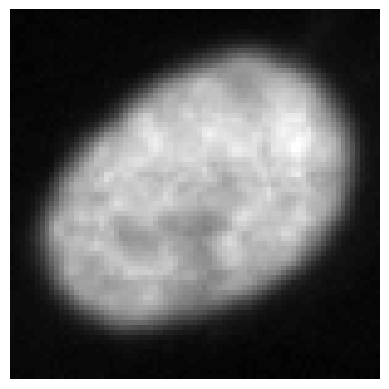

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
im_path = "/content/cell_img_resize_f/8989.png" # Update the path to your image
image = Image.open(im_path)
print(image.size)
im=np.array(image)
plt.imshow(image,cmap="gray")
plt.axis('off')
plt.show()

The dataset is imabalnced and doesnt have equal distribution of images

In [ ]:
label_data = pd.read_csv("/content/drive/MyDrive/cell_classification/cell_label.csv")
label_counts = label_data['label'].value_counts().sort_index()
print(label_counts)


1    14367
2    14655
3    13257
4    13737
5     5086
6     2343
Name: label, dtype: int64


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

label_data = pd.read_csv("/content/drive/MyDrive/cell_classification/cell_label.csv") # load csv file paths
label_data['label'] = label_data['label'].astype(str) # convert labels to string

train_df, test_df = train_test_split(label_data, test_size=0.2, stratify=label_data['label'], random_state=42)



train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# using ImageDataGenerator to encode each image to its label and create batches of size 32 after rescaling the images
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='cell_img_resize_f',
    x_col='image_name',
    y_col='label',
    target_size=(75,75),
    batch_size=32,
    class_mode='categorical')

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory='cell_img_resize_f',
    x_col='image_name',
    y_col='label',
    target_size=(75,75),
    batch_size=32,
    class_mode='categorical')



Found 50756 validated image filenames belonging to 6 classes.
Found 12689 validated image filenames belonging to 6 classes.


Here the flow_from_dataframe method encodes 1 to 0 and like wise(hot encoding). train_generator is a tupple that has batches of size 32 with 75*75 pixel images with 3 color channels and other tupple containing corresponding label

In [ ]:
label_map = train_generator.class_indices
print(label_map)
print(len(test_generator))
print(len(train_generator))
batch_img,batch_label=test_generator[0]
print(np.shape(batch_img))
print(np.shape(batch_label))

{'1': 0, '2': 1, '3': 2, '4': 3, '5': 4, '6': 5}
397
1587
(32, 75, 75, 3)
(32, 6)


Use of GPU runtime is required for faster implementation

In [ ]:
#CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(75, 75, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(6, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])




# **Model performance analysis**

Here from the history of epochs the loss,f1_score and accuracy are calculated and the test_data is evaluated for  same metrics and stored in arrays

In [ ]:
import numpy as np
from sklearn.metrics import f1_score

losses_test = []
accuracies_test = []
f1_scores_test = []
losses_train = []
accuracies_train = []
f1_scores_train = []


for epoch in range(10):
    history = model.fit(train_generator, epochs=1)
    train_loss, train_accuracy = model.evaluate(train_generator)
    test_loss, test_accuracy = model.evaluate(test_generator)

    y_true_test = test_generator.classes
    y_pred_probs_test = model.predict(test_generator)


    y_pred_test = np.argmax(y_pred_probs_test, axis=1)


    f1_test = f1_score(y_true_test, y_pred_test, average='macro')


    y_true_train = train_generator.classes
    y_pred_probs_train = model.predict(train_generator)


    y_pred_train = np.argmax(y_pred_probs_train, axis=1)


    f1_train = f1_score(y_true_train, y_pred_train, average='macro')

    losses_test.append(test_loss)
    accuracies_test.append(test_accuracy)
    f1_scores_test.append(f1_test)
    losses_train.append(train_loss)
    accuracies_train.append(train_accuracy)
    f1_scores_train.append(f1_train)

    print("Epoch:", epoch+1)
    print("Training Loss:", train_loss)
    print("Training Accuracy:", train_accuracy)
    print("Test Loss:", test_loss)
    print("Test Accuracy:", test_accuracy)
    print("F1 Score (Test):", f1_test)
    print("F1 Score (Training):", f1_train)


1587/1587 [==============================] - 34s 21ms/step
Epoch: 1
Training Loss: 0.6340481638908386
Training Accuracy: 0.7577035427093506
Test Loss: 0.6616449952125549
Test Accuracy: 0.7502561211585999
F1 Score (Test): 0.1670379025966814
F1 Score (Training): 0.16361810689808529
1587/1587 [==============================] - 35s 22ms/step
Epoch: 2
Training Loss: 0.4935353696346283
Training Accuracy: 0.8083182573318481
Test Loss: 0.5536921620368958
Test Accuracy: 0.7936007380485535
F1 Score (Test): 0.16600579223081258
F1 Score (Training): 0.1639874050634544
1587/1587 [==============================] - 33s 21ms/step
Epoch: 3
Training Loss: 0.4161948263645172
Training Accuracy: 0.8398810029029846
Test Loss: 0.5068943500518799
Test Accuracy: 0.808259129524231
F1 Score (Test): 0.15945447719880623
F1 Score (Training): 0.16497880346738286
1587/1587 [==============================] - 35s 22ms/step
Epoch: 4
Training Loss: 0.34021928906440735
Training Accuracy: 0.8764086961746216
Test Loss: 0.466

In [ ]:
losses_test = [round(l, 2) for l in losses_test]
accuracies_test = [round(a, 2) for a in accuracies_test ]
f1_scores_test = [round(f, 2) for f in f1_scores_test]
losses_train = [round(l, 2) for l in losses_train]
accuracies_train = [round(a, 2) for a in accuracies_train ]
f1_scores_train = [round(f, 2) for f in f1_scores_train]


Using sklearns classification_report we can obtain information on the f1_scores of each label during each epoch

**Graphs**

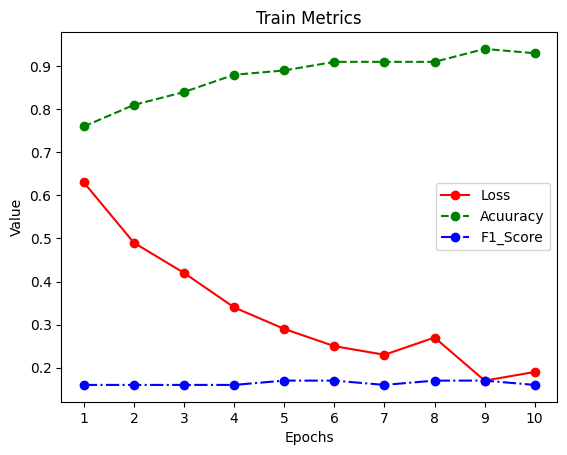

In [ ]:
x=np.array([i for i in range(1,11)])
plt.plot(x,losses_train,"ro-",label="Loss")
plt.plot(x,accuracies_train,"go--",label="Acuuracy")
plt.plot(x,f1_scores_train,"bo-.",label="F1_Score")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend()
plt.xticks(x)
plt.title("Train Metrics")
plt.show()


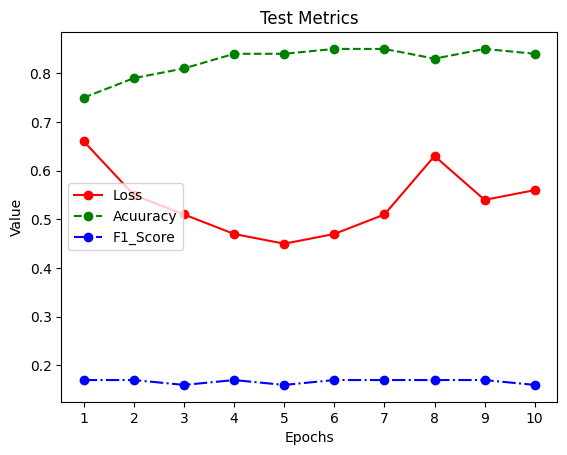

In [ ]:
x=np.array([i for i in range(1,11)])
plt.plot(x,losses_test,"ro-",label="Loss")
plt.plot(x,accuracies_test,"go--",label="Acuuracy")
plt.plot(x,f1_scores_test,"bo-.",label="F1_Score")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend()
plt.title("Test Metrics")
plt.xticks(x)
plt.show()


Here it is evident that during training the accuracy reaches close to 90%  and the loss is minimal but f1-score is low.It is possibly due imbalanced dataset that is resposnible for low f1-score.From the testing graph it is evident tha f1-score remains nearly the same. To  improve f1-score we could tune the hyperparametrs like decrease batch size or change complexity of the CNN. f1-score could be improved by using a more balanced dataset

**Confusion Matrix**

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix



confusion_mtx_test = confusion_matrix(y_true_test, y_pred_test)
print("Confusion Matrix (Test):")
print(confusion_mtx_test)


confusion_mtx_train = confusion_matrix(y_true_train, y_pred_train)
print("Confusion Matrix (Training):")
print(confusion_mtx_train)



Confusion Matrix (Test):
[[712 640 645 585 211  80]
 [716 626 626 645 217 101]
 [649 584 604 545 201  68]
 [678 593 656 517 214  90]
 [247 240 196 220  78  36]
 [109  97 105 103  39  16]]
Confusion Matrix (Training):
[[2735 2456 2504 2434  958  407]
 [2835 2619 2460 2461  954  395]
 [2532 2261 2334 2251  857  371]
 [2713 2427 2396 2244  859  350]
 [1029  911  875  822  300  132]
 [ 452  391  421  397  161   52]]


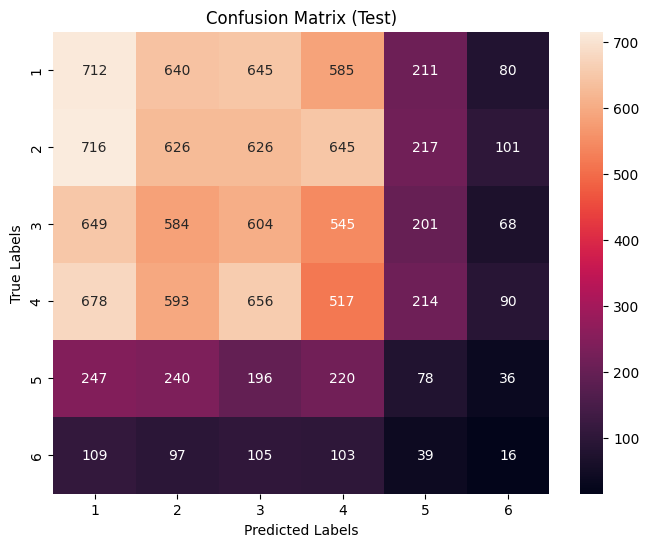

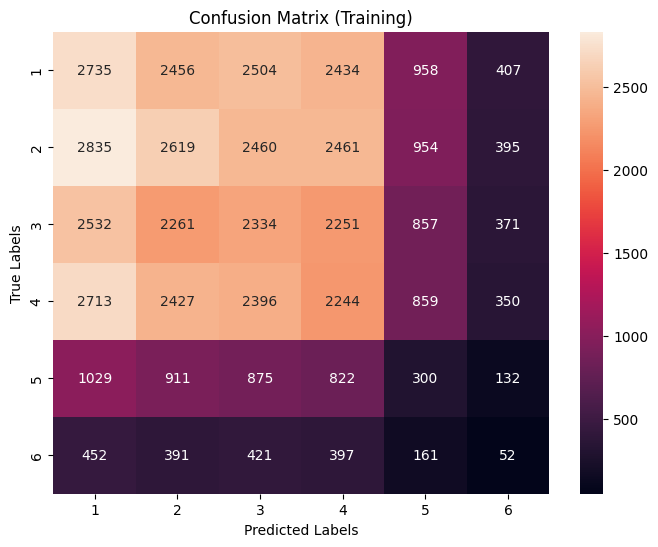

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


class_labels = ['1', '2', '3', '4', '5', '6']


plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx_test, annot=True, fmt="d",  xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix (Test)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx_train, annot=True, fmt="d",  xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix (Training)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()
